#Lab 9: Transfer Learning/Fine-Tuning

## Description

### Objective

- Gain experience fine-tuning pre-trained models to domain-specific applications.

### Deliverable

For this lab you will submit an ipython notebook via learning suite. The bulk of the work is in fine-tuning a pre-trained ResNet. Fine-tuning the GPT-2 language model is pretty easy. The provided code works as is; you will just have to swap in your own text dataset.

### Grading

- 35% Create a dataset class for your own dataset
- 35% Create a network class that wraps a pretrained ResNet
- 20% Implement unfreezing in the network class
- 10% Fine-tune GPT-2 on your own dataset

### Tips
- Your life will be better if you download a dataset that already has the data in the expected format for ImageFolder (make sure to read the documentation!). The datasets recommended below are in the correct format.
- Get the CNN working on the provided dataset (bird species classification) before swapping in your own.
- For reference on freezing/unfreezing network weights, see [this github gist](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c)
- For training GPT-2, first try the medium-size (355M parameter) model. If your Colab instance doesn't have enough GPU space, you may need to switch to the small-size (124M parameter) model, but the results will be less impressive.

In [1]:
import torchvision
from torchvision.models import resnet152
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch
from torch import optim, nn
import zipfile
from google.colab import files
import os
import sys
from PIL import Image, ImageOps
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt

## 1 Fine-tune a ResNet for image classification

### 1.1 Find a dataset to fine-tune on, and make a Dataset class (1 hr.)

#### TODO:

- Inherit from torch.utils.data.Dataset
- Use a [torchvision.datasets.ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder)
- Don't spend too long finding another dataset. Some suggestions that you are free to use:
 - https://www.kaggle.com/akash2907/bird-species-classification
 - https://www.kaggle.com/jessicali9530/stanford-dogs-dataset
 - https://www.kaggle.com/puneet6060/intel-image-classification


#### Help for downloading kaggle datasets
Downloading Kaggle datasets requires authentication, so you can't just download from a url. Here are some step-by-step instructions of how to get Kaggle datasets in Colab

1. Create an API key in Kaggle
    - Click on profile photo
    - Go to 'My Account'
    - Scroll down to the API access section and click "Create New API Token"
    - `kaggle.json` is now downloaded to your computer

2. Upload the API key and install the Kaggle API client by running the next cell (run it again if it throws an error the first time). Also, `files.upload()` may not work in Firefox. One solution is to expand the Files banner (indicated by the '>' tab on the left side of the page) and use that to upload the key.

In [2]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 62 Mar 13 01:43 kaggle.json


3. Copy the desired dataset locally

In [3]:
# Example download command for dataset found here: https://www.kaggle.com/akash2907/bird-species-classification
# !kaggle datasets download -d akash2907/bird-species-classification

# Download the Intel Images dataset (referenced above)
!kaggle datasets download -d puneet6060/intel-image-classification

 99% 343M/346M [00:09<00:00, 51.0MB/s]
100% 346M/346M [00:09<00:00, 38.7MB/s]


#### Make the Dataset class
See the implementation below for reference, and make your own.

In [ ]:
# class BirdDataset(Dataset):
#     def __init__(self, zip_file='./bird-species-classification.zip', size=256, train=True, upload=False):
#         super(BirdDataset, self).__init__()
        
#         self.train = train
#         extract_dir = os.path.splitext(zip_file)[0]
#         if not os.path.exists(extract_dir):
#             os.makedirs(extract_dir)
#             self.extract_zip(zip_file, extract_dir)
#             # Resize the images - originally they are high resolution. We could do this
#             # in the DataLoader, but it will read the full-resolution files from disk
#             # every time before resizing them, making training slow
#             self.resize(extract_dir, size=size)

#         postfix = 'train' if train else 'test'
            
#         if train:
#             # The bird-species dataset mistakenly has a train_data folder inside of train_data
#             self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'train_data', 'train_data'), transform=transforms.Compose([transforms.ToTensor()]))
#         else:
#             self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'test_data', 'test_data'), transform=transforms.Compose([transforms.ToTensor()]))

#     def extract_zip(self, zip_file, extract_dir):
#         print("Extracting", zip_file)
#         with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#             zip_ref.extractall(extract_dir)

#     def resize(self, path, size=256):
#         """Resizes all images in place"""
#         print("Resizing images")
#         dirs = os.walk(path)
#         for root, dirs, files in os.walk(path):
#             for item in files:
#                 name = os.path.join(root, item)
#                 if os.path.isfile(name):
#                     im = Image.open(name)
#                     im = ImageOps.fit(im, (size, size))
#                     im.save(name[:-3] + 'bmp', 'BMP')
#                     os.remove(name)

#     def __getitem__(self, i):
#         return self.dataset_folder[i]

#     def __len__(self):
#         return len(self.dataset_folder)

# bird_data = BirdDataset()

Here, I use the Intel Image Classification dataset referenced above. It can be found at: https://www.kaggle.com/puneet6060/intel-image-classification.

Even with a GPU, the Intel dataset takes 6hrs of training time per epoch. I implemented the Intel dataset properly and you can run this notebook using this dataset, but training will take much longer. I recommend using the custom vehicle images dataset from the cells below.

The Intel Images dataset has a folder structure like this:

```python
# intel-image-classification
# --> seg_pred
#   --> seg_pred
#       --> 10004.jpg
#       --> ...
# --> seg_test
#   --> seg_test
#       --> buildings
#           --> 20057.jpg
#           --> ...
#       --> forest
#       --> glacier
#       --> mountain
#       --> sea
#       --> street
# --> seg_train
#   --> seg_train
#       --> buildings
#           --> 0.jpg
#           --> ...
#       --> forest
#       --> glacier
#       --> mountain
#       --> sea
#       --> street
```



In [4]:
# ==========================
# Implement your own Dataset
# ==========================
class IntelDataset(Dataset):
    def __init__(self, zip_file='./intel-image-classification.zip', 
                 height_resize=100, width_resize=100, train=True, upload=False):
        super().__init__()
        
        self.train = train
        extract_dir = os.path.splitext(zip_file)[0]
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
            self.extract_zip(zip_file, extract_dir)
            # Resize the images - originally they are high resolution. We could do this
            # in the DataLoader, but it will read the full-resolution files from disk
            # every time before resizing them, making training slow
            self.resize(extract_dir, height=height_resize, width=width_resize)
            
        if train:
            # The Intel Image Classification dataset has a folder structure like this:
            # intel-image-classification --> seg_train --> seg_train --> (folders for each class)
            # intel-image-classification --> seg_test --> seg_test --> (folders for each class)
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'seg_train', 'seg_train'), transform=transforms.Compose([transforms.ToTensor()]))
        else:
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'seg_test', 'seg_test'), transform=transforms.Compose([transforms.ToTensor()]))

    def extract_zip(self, zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f'Done! Image dataset extracted to {extract_dir}')

    def resize(self, path, size=150):
        """Resizes all images in place"""
        print("Resizing images")
        dirs = os.walk(path)
        for root, dirs, files in os.walk(path):
            for item in files:
                name = os.path.join(root, item)
                if os.path.isfile(name):
                    im = Image.open(name)
                    im = ImageOps.fit(im, (size, size))
                    im.save(name[:-3] + 'bmp', 'BMP')
                    os.remove(name)
        print(f'Done! All images resized to {size} by {size} pixels.')

    def __getitem__(self, i):
        return self.dataset_folder[i]

    def __len__(self):
        return len(self.dataset_folder)


# Instantiate the dataset
intel_data = IntelDataset()

Extracting ./intel-image-classification.zip
Done! Image dataset extracted to ./intel-image-classification
Resizing images


### My custom dataset: vehicle images
I'm using this dataset because it is much smaller than the Intel one, so it trains faster.

I use a custom image dataset I scraped from CarAndDriver.com (after reviewing the site's [robots.txt](https://www.caranddriver.com/robots.txt) page, which allows algorithmic access to the content I selected).

**Source: CarAndDriver.com**

vehicle_specs.csv (650 images)

https://raw.githubusercontent.com/rparkr/ML-practice/main/Vehicle%20specs/Final%20project/vehicle_specs.csv

In [2]:
import pandas as pd             # store and analyze tabular data (like .csv files)
import requests                 # access and download web content
import os                       # manage directories
from tqdm.notebook import tqdm  # create progress bars
import time                     # pause code execution
import random                   # create random train/test splits
from PIL import Image           # image manipulation
from io import BytesIO          # processing bytestreams (downloaded images)

In [3]:
# Create training and test sets from a given list
def train_test_split(input_list, train_split_pct = 0.7):
    '''
    Takes `input_list` and returns a tuple: `(train_list, test_list)`,
    where both lists are created from a random sample from the input_list.

    `train_split_pct` sets the percentage of items from input_list that
    will be included in the `train_list`. All items not selected for the
    `train_list` are included in the `test_list`.
    '''
    sample_size = int(round(len(input_list) * train_split_pct, 0))
    train_list = random.sample(input_list, k=sample_size)
    test_list = [item for item in input_list if item not in train_list]
    return train_list, test_list

In [4]:
sample_list = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
train_list, test_list = train_test_split(sample_list, 0.6)
print(train_list)
print(test_list)

['O', 'H', 'N', 'E', 'R', 'S', 'W', 'T', 'F', 'C', 'B', 'Y', 'Z', 'I', 'J', 'Q']
['A', 'D', 'G', 'K', 'L', 'M', 'P', 'U', 'V', 'X']


In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/rparkr/ML-practice/main/Vehicle%20specs/Final%20project/vehicle_specs.csv')

# Keep only the columns needed: Year, Make, Model, and Image URL
df = df[['Year', 'Make', 'Model', 'Body_style', 'Image']].dropna()

body_style_replace = {
    'sedan': 'car',
    'coupe': 'car',
    'convertible': 'car',
    'station wagon': 'hatchback',
    'station-wagon': 'hatchback'
}

# Combine similar values of body_style to reduce the number of categories
for key, val in body_style_replace.items():
    df.loc[df['Body_style'] == key, 'Body_style'] = val

# Sort the DataFrame by the category column, and reset the index
df = df.sort_values(by=['Body_style'], ignore_index=True)

# List images in a dictionary by category
# img_catgories = {
#     'car': {'all': ['img_01.jpg', 'img_02.jpg'],
#             'urls': ['https://example.com/img01.jpg', ...],
#             'train': ['img_01.jpg'],
#             'test': ['img_02.jpg']},
#     'car': {'all': ['img_03.jpg', 'img_04.jpg'],
#             'urls': ['https://example.com/img03.jpg', ...],
#             'train': ['img_03.jpg'],
#             'test': ['img_04.jpg']},
#     ...
# }
img_categories = {}
for catg in df['Body_style'].unique().tolist():
    img_categories[catg] = {'all': [], 'urls': [], 'train': [], 'test': []}

# Populate the dictionary, which will store the folder structure of the dataset
for n, year, make, model, body_style, image_url in df.itertuples():
    # Capture the final 4 characters of the URL (the image type)
    filetype_start = image_url.rfind('.')
    filetype = image_url[filetype_start:]
    # Name the file: n_bodystyle.jpg
    filename = f'{n}_{body_style}{filetype}'
    # Add to dictionary
    img_categories[body_style]['all'].append(filename)
    img_categories[body_style]['urls'].append(image_url)

# Create the training and testing splits
for catg in img_categories:
    train, test = train_test_split(img_categories[catg]['all'], train_split_pct=0.8)
    img_categories[catg]['train'] = train
    img_categories[catg]['test'] = test

print(f'Done! Dictionary loaded with {len(df.index)} images.')
print('Example:')
img_categories['pickup']['test']

Done! Dictionary loaded with 643 images.
Example:


['387_pickup.jpg',
 '389_pickup.jpg',
 '393_pickup.jpg',
 '394_pickup.jpg',
 '396_pickup.jpg']

Create a function to resize images and then save them to folders in the format expected by `torchvision.datasets.ImageFolder`. See: https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

In [6]:
def resize_and_save(img_dict_folder_structure, resize_dims=(242, 148)):
    '''
    Takes as input the `img_dict_folder_structure`, which is the
    `img_categories` dictionary created in the previous cell.

    Creates folders in the current working directory in the structure
    expected by torchvision.datasets.ImageFolder.

    Downloads images from URLs, then resizes them, then saves them
    to the folders created in this function.

    Package dependencies:
    - os
    - io.BytesIO
    - PIL.Image
    - requests
    - tqdm (progress bars)
    '''
    # Save images to folders
    # ======================
    catg_dict = img_dict_folder_structure

    # Create folders if they do not already exist
    if not os.path.exists('./vehicles'):
        for mode in ['train', 'test']:
            for catg in catg_dict.keys():
                os.makedirs(f'./vehicles/{mode}/{catg}')
    
    progress = tqdm(total=sum([len(catg_dict[catg]['all']) for catg in catg_dict]))
    
    # Loop through image folder dictionary
    for catg in catg_dict:
        for mode in ['train', 'test']:
            for item in catg_dict[catg][mode]:
                item_index = catg_dict[catg]['all'].index(item)
                img_url = catg_dict[catg]['urls'][item_index]    
                # Download image (binary file)
                img_to_save = requests.get(img_url).content
                try:
                    with Image.open(BytesIO(img_to_save)) as img:
                        # Use PIL to convert to RGB (in case the image is RGBA)
                        # See: https://pillow.readthedocs.io/en/latest/handbook/concepts.html#modes
                        # And: https://www.kite.com/python/answers/how-to-convert-a-rgba-image-to-a-rgb-image-with-pil-in-python
                        if img.mode == 'RGBA':
                            img = img.convert(mode='RGB')
                        # Resize image in the dimensions: width x height
                        img = img.resize(size=resize_dims)
                        # Save image
                        img.save(f'./vehicles/{mode}/{catg}/{item}', format='JPEG')
                except Image.UnidentifiedImageError:
                    print(f'Could not save {mode} image {item} with url {img_url}')
                # Update progress bar
                progress.update(n=1)
                # Pause for 10 milliseconds, as requested by CarAndDriver.com/robots.txt
                time.sleep(0.01)

In [7]:
resize_and_save(img_categories, resize_dims=(242, 148))

  0%|          | 0/643 [00:00<?, ?it/s]

Could not save train image 128_car.jpg with url https://hips.hearstapps.com/amv-prod-cad-assets.s3.amazonaws.com/media/assets/submodel/6760.jpg
Could not save train image 47_car.jpg with url https://hips.hearstapps.com/amv-prod-cad-assets.s3.amazonaws.com/media/assets/submodel/8597.jpg
Could not save train image 172_car.jpg with url https://hips.hearstapps.com/amv-prod-cad-assets.s3.amazonaws.com/media/assets/submodel/4506.jpg
Could not save train image 316_hatchback.jpg with url https://hips.hearstapps.com/amv-prod-cad-assets.s3.amazonaws.com/media/assets/submodel/7184.jpg
Could not save train image 355_hatchback.jpg with url https://hips.hearstapps.com/amv-prod-cad-assets.s3.amazonaws.com/media/assets/submodel/8825.jpg


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (134497676 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Could not save test image 586_suv.jpg with url https://hips.hearstapps.com/amv-prod-cad-assets.s3.amazonaws.com/media/assets/submodel/8409.jpg


### Dataset class

References
* https://github.com/utkuozbulak/pytorch-custom-dataset-examples
* https://pytorch.org/vision/stable/datasets.html
* https://pytorch.org/docs/stable/data.html

Note on transforms

The images have the aspect ratio (800/489 = 1.635). I resized the images to (242w x 148h) to preserve the aspect ratio and saved them to a folder.

In the Dataset class implemented below, I take a center crop of (128h x 128w).

In [8]:
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class vehicle_dataset(Dataset):
    def __init__(self, path_to_folder, train=True, center_crop_size=148):
        # No need to inherit from the base class (torch.utils.data.Dataset)
        # That is, we don't need: super().__init__()
        self.tforms = transforms.Compose(
            [
                # transforms.CenterCrop(center_crop_size),
                transforms.ToTensor()
            ])
        
        if train:
            self.dataset_folder = torchvision.datasets.ImageFolder(
                path_to_folder + '/train/',
                transform=self.tforms)
        else:
            self.dataset_folder = torchvision.datasets.ImageFolder(
                path_to_folder + '/test/',
                transform=self.tforms)

    def __getitem__(self, index):
        return self.dataset_folder[index]
    
    def __len__(self):
        return len(self.dataset_folder)

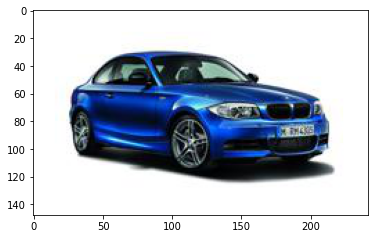

In [9]:
import matplotlib.pyplot as plt

vehicle_train_dataset = vehicle_dataset('./vehicles', train=True)
vehicle_test_dataset = vehicle_dataset('./vehicles', train=False)
img_tensor = vehicle_train_dataset[122]

plt.imshow(img_tensor[0].transpose(0,2).transpose(0,1).cpu().numpy())

### 1.2 Wrap a pretrained ResNet in an `nn.Module` (30 min)

#### TODO:

- Make a model class that inherits from `nn.Module`
- Wrap a pretrained ResNet and swap out the last layer of that network with a layer that maps to the number of classes in your new dataset

#### Make your model class

In [10]:
class ResNetVehicles(nn.Module):
    def __init__(self, num_classes, start_frozen=False):
        super().__init__()

        # Part 1.2
        # Load the model - make sure it is pre-trained
        self.model = torchvision.models.resnet152(pretrained=True, progress=True)

        # Store a dictionary with model layers, to use for unfreezing
        self.model_layers = {n:child for n, child in enumerate(self.model.children())}

        # The -1 sets the layer count to a 0-based index
        self.num_layers = len(self.model_layers)

        # Part 1.4
        if start_frozen:
            # Turn off all gradients of the resnet
            for param in self.model.parameters():
                param.requires_grad = False

        # Part 1.2
        # Look at the code of torchvision.models.resnet152 to find the name of the attribute to override (the last layer of the resnet)
        # Override the last layer of the neural network to map to the correct number of classes. Note that this new layer has requires_grad = True
        # See: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L204
        # Also: https://pytorch.org/vision/master/generated/torchvision.models.resnet152.html
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        for param in self.model.fc.parameters():
            param.requires_grad = True
        
    def unfreeze(self, n_layers):
        # Part 1.4
        # Turn on gradients for the last n_layers
        for layer_num in self.model_layers:
            if layer_num > (self.num_layers - n_layers):
                # Unfreeze parameters in the layer
                for param in self.model_layers[layer_num].parameters():
                    param.requires_grad = True

    def forward(self, x):
        # Part 1.2
        # Pass x through the resnet
        return self.model(x)

### 1.3 Read through and run this training loop

In [11]:
def accuracy(y_hat, y_truth):
    """Gets average accuracy of a vector of predictions"""
    
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc

def evaluate(model, objective, val_loader, device):
    """Gets average accuracy and loss for the validation set"""

    val_losses = []
    val_accs = []
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()
    # torch.no_grad() to turn off computation graph creation. This allows for temporal
    # and spatial complexity improvements, which allows for larger validation batch 
    # sizes so it’s recommended
    with torch.no_grad():
        for x, y_truth in val_loader:

            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)
            val_loss = objective(y_hat, y_truth)
            val_acc = accuracy(y_hat, y_truth)

            val_losses.append(val_loss.item())
            val_accs.append(val_acc)
    # Return model to training mode (for batchnorm and dropout)
    model.train()

    return torch.mean(torch.Tensor(val_losses)), torch.mean(torch.Tensor(val_accs))

In [17]:
def train(start_frozen=False, num_classes=5, model_unfreeze=0, epochs=8):
    """Fine-tunes a CNN
    Args:
        start_frozen (bool): whether to start with the network weights frozen.
        model_unfreeze (int): the maximum number of network layers to unfreeze
    """
    # Start with a very low learning rate
    lr = .00005
    val_every = 2
    batch_size = 32
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data
    train_dataset = vehicle_dataset('./vehicles', train=True)
    val_dataset = vehicle_dataset('./vehicles', train=False)
    train_loader = DataLoader(train_dataset,
                              shuffle=True,
                              num_workers=2,
                              batch_size=batch_size)
    val_loader = DataLoader(val_dataset,
                              shuffle=True,
                              num_workers=2,
                              batch_size=batch_size)
    
    # Model
    model = ResNetVehicles(num_classes, start_frozen=start_frozen).to(device)
    
    # Objective
    objective = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-1)

    # Progress bar
    pbar = tqdm(total=len(train_loader) * epochs)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    cnt = 0
    for epoch in range(epochs):

        # Implement model unfreezing
        if (epoch+1) < model_unfreeze:
            # Part 1.4
            # Unfreeze the last layers, one more each epoch
            model.unfreeze(epoch+1)
        
        for x, y_truth in train_loader:
        
            x, y_truth = x.to(device), y_truth.to(device)

            optimizer.zero_grad()

            y_hat = model(x)
            train_loss = objective(y_hat, y_truth)
            train_acc = accuracy(y_hat, y_truth)

            train_loss.backward()
            optimizer.step()

            train_accs.append(train_acc.item())
            train_losses.append(train_loss.item())

            if cnt % val_every == 0:
                val_loss, val_acc = evaluate(model, objective, val_loader, device)
                val_losses.append(val_loss.item())
                val_accs.append(val_acc.item())

            pbar.set_description('train loss: {:.4f}, train accuracy: {:.4f}'.format(train_loss.item(), train_acc))
            pbar.update(1)
            cnt += 1

    pbar.close()
    plt.subplot(121)
    plt.plot(np.arange(len(train_accs)), train_accs, label='Train Accuracy')
    plt.plot(np.arange(len(train_accs), step=val_every), val_accs, label='Val Accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(np.arange(len(train_losses), step=val_every), val_losses, label='Val Loss')
    plt.legend()
    plt.show()  

In [ ]:
# train(start_frozen=True, model_unfreeze=0)  

### 1.4 Implement Unfreezing (1 hr)

#### Description

Unfreezing is a technique that can be helpful when fine tuning a CNN for a more difficult task with a large amount of data.

The idea is that if we allow the network to tweak the earliest layers immediately, before the last FCL has been trained at all, the earliest layers will forget all of the useful features that they learned in order  to provide features that are helpful for the (untrained) FCL.

So, rather than training all of the model weights at once, we learn the last fully connected layer, then train that layer together with the second-to-last layer, gradually adding layers until we reach the first layer.

#### TODO:

- Modify your model class by setting the `requires_grad` attribute of the ResNet to `False`. (but keep `requires_grad = True` for the last layer).
- Add a member function to you model class that allows the user to unfreeze weights in the training loop. See [this github gist](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c) for reference.
- Modify your training loop to add logic that calls the `unfreeze` function of the model class (unfreeze one layer every epoch).
- Call your train function to fine-tune the ResNet on your dataset.

#### Call your train function

  0%|          | 0/128 [00:00<?, ?it/s]

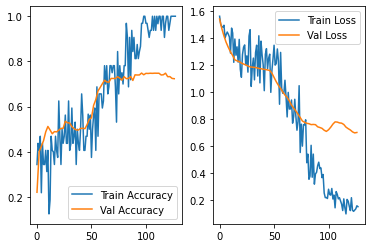

In [18]:
# =================================================
# train with unfreezing here 
# (should be a single call to your train function)
# =================================================

train(start_frozen=True, num_classes=5, model_unfreeze=8, epochs=8)  

You may not see any improvement for your classification task, but unfreezing can help convergence for more difficult image classification tasks.

##2 Fine-tune a language model - (15 min)

In this section you will use the gpt-2-simple package [here](https://github.com/minimaxir/gpt-2-simple) to fine-tune the GPT-2 language model on a domain of your choice.

### 2.1 Generate text from the pretrained GPT-2 model

#### Run this code to generate text from a pretrained model

In [1]:
%pip install gpt-2-simple

# the transformers package is built on top of Tensorflow, and the default TF version 
# for Colab will soon switch to 2.x. We remedy this with the following magic method
%tensorflow_version 1.x 

import gpt_2_simple as gpt2
import os
import tensorflow as tf

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# This line is necessary to be able to run a new tf session
tf.reset_default_graph()
# The medium-sized model is "355M". If you run out of memory, try "124M" instead
model_name = "124M"
if not os.path.isdir(os.path.join("models", model_name)):
	print(f"Downloading {model_name} model...")
	gpt2.download_gpt2(model_name=model_name)   # model is saved into current directory under /models/355M/

sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, model_name=model_name)

Fetching checkpoint: 1.05Mit [00:00, 624Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 2.69Mit/s]
Fetching hparams.json: 1.05Mit [00:00, 593Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:17, 27.7Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 522Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 3.56Mit/s]
Fetching vocab.bpe: 1.05Mit [00:00, 3.12Mit/s]


Loading pretrained model models/124M/model.ckpt
INFO:tensorflow:Restoring parameters from models/124M/model.ckpt


In [3]:
gpt2.generate(sess, model_name=model_name)

Once upon a time, the world had been a land of gods and heroes, where the gods trusted the heroes to survive and provide for the people. The gods had been great, and had set up all the gods to be the gods of our time. But now, they were in decline.

The gods had lost their ability to fight, their governments were crumbling and icy, and it was time to stop the fall of the nations.

I'm not talking about the Altar of the Ancients, where the heroes were all dead; I'm talking about the Altar of the Young Gods.

The Young Gods were the most powerful of all the gods, and the one they had to wield the most power because they were the only ones who would ever see the light of their power.

When the arc of the universe ended, the gods would simply vanish.

They'd been forgotten.

They'd been all but forgotten.

And what could they possibly do with all that power now? What would they possibly do with all this power?

Was it just a false sense of betrayal or just a false sense of hope?

The answe

### 2.2 Download a text dataset

#### TODO:

- Use the provided functions to download your own text dataset
- [Project Gutenberg](https://www.gutenberg.org/) is a nice starting point for raw text corpora

#### Download Dataset

In [ ]:
# import zipfile
# import os
# from torchvision import datasets

# def extract_zip(zip_path, remove_finished=True):
#     print('Extracting {}'.format(zip_path))
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(zip_path.replace('.zip', ''))
#     if remove_finished:
#         os.remove(zip_path)

# def download_dataset(url, root='../data'):
#     if not os.path.exists(os.path.join(root, 'text')):
#         os.makedirs(os.path.join(root))
#         datasets.utils.download_url(url, root, 'text.zip', None)
#         extract_zip(os.path.join(root, 'text.zip'))
#     return os.path.join(root, 'text')

# ##########################################
# # Set the url for your dataset here,
# # move the dataset to the desired location
# ##########################################
# url = 'https://www.gutenberg.org/files/30/30.zip'
# download_dataset(url)
# !mv /data/text/30.txt /data/text/bible.txt
# !ls ../data/text

mv: cannot stat '/data/text/30.txt': No such file or directory
bible.txt


My custom dataset: the full text of six books from Jane Austen.

In [4]:
import re        # regular expressions, for extracting text from books
import requests  # for accessing books from URLs
import os        # for creating directory to store books

book_names = [
    'Pride and Prejudice',
    'Emma',
    'Sense and Sensibility',
    'Persuasion',
    'Northanger Abbey',
    'Mansfield Park',
    'Lady Susan'
]

book_urls = [
    'https://www.gutenberg.org/files/1342/1342-0.txt',
    'https://www.gutenberg.org/cache/epub/158/pg158.txt',
    'https://www.gutenberg.org/files/161/161-0.txt',
    'https://www.gutenberg.org/cache/epub/105/pg105.txt',
    'https://www.gutenberg.org/files/121/121-0.txt',
    'https://www.gutenberg.org/files/141/141-0.txt',
    'https://www.gutenberg.org/cache/epub/946/pg946.txt'
]

# Create a folder to save the books in
if not os.path.exists('./books/'):
    os.mkdir('./books/')

jane_austen_full_text = ''

# Save books to a folder so they can be accessed later if needed
# Also save the entire text in the jane_austen_full_text variable
for num, url in enumerate(book_urls):
    response = requests.get(url)
    # Ensure the response text is properly formatted as utf-8
    # See: https://stackoverflow.com/a/44203507/17005348
    response.encoding = 'UTF-8'
    book_text = response.text
    book_title = book_names[num].replace(' ', '_')
    with open(f'./books/{book_title}.txt', mode='w+', encoding='utf-8') as book_file:
        book_file.write(book_text)
    
    # Save the text to the jane_austen_full_text variable,
    # removing the intro and end parts from Project Gutenberg
    # which have this form: *** BEGIN BOOK *** or *** END OF BOOK ***
    jane_austen_full_text += re.split(r'[*]{3}.*?[*]{3}', string=book_text)[1]

with open(f'./books/jane_austen.txt', mode='w+', encoding='utf-8') as book_file:
        book_file.write(jane_austen_full_text)

print(f'Total number of characters: {len(jane_austen_full_text):,d}')

Total number of characters: 4,296,653


### 2.3 Fine-tune GPT-2 on your own dataset

#### TODO:

- Swap out the dataset parameter with the path to your dataset

#### Train on your dataset

In [6]:
# This line is necessary to be able to run a new tf session if one has already been run
tf.reset_default_graph()
# Start a session
sess = gpt2.start_tf_sess()
# Fine tune `model_name` on `data`
###################################
# Swap out the `dataset` parameter with the path to your text dataset
###################################
gpt2.finetune(sess,
              dataset='./books/jane_austen.txt',
              model_name=model_name,
              restore_from='latest',
              use_memory_saving_gradients = True,
              only_train_transformer_layers= True,
              accumulate_gradients = 1,
              steps=100)   # steps is max number of training steps

Loading checkpoint models/124M/model.ckpt
INFO:tensorflow:Restoring parameters from models/124M/model.ckpt
Loading dataset...


100%|██████████| 1/1 [00:04<00:00,  4.61s/it]


dataset has 1112424 tokens
Training...
[1 | 3.77] loss=3.70 avg=3.70
[2 | 4.32] loss=2.81 avg=3.25
[3 | 4.87] loss=3.77 avg=3.43
[4 | 5.42] loss=3.58 avg=3.46
[5 | 5.97] loss=3.55 avg=3.48
[6 | 6.53] loss=3.52 avg=3.49
[7 | 7.08] loss=3.93 avg=3.55
[8 | 7.64] loss=3.62 avg=3.56
[9 | 8.19] loss=4.10 avg=3.62
[10 | 8.74] loss=3.46 avg=3.61
[11 | 9.30] loss=3.45 avg=3.59
[12 | 9.85] loss=3.63 avg=3.60
[13 | 10.40] loss=3.61 avg=3.60
[14 | 10.96] loss=3.18 avg=3.57
[15 | 11.51] loss=3.71 avg=3.58
[16 | 12.07] loss=3.00 avg=3.54
[17 | 12.62] loss=3.29 avg=3.52
[18 | 13.18] loss=3.28 avg=3.51
[19 | 13.73] loss=3.29 avg=3.49
[20 | 14.29] loss=3.31 avg=3.48
[21 | 14.84] loss=3.12 avg=3.47
[22 | 15.41] loss=3.71 avg=3.48
[23 | 15.97] loss=3.40 avg=3.47
[24 | 16.52] loss=3.73 avg=3.49
[25 | 17.07] loss=3.73 avg=3.50
[26 | 17.63] loss=3.08 avg=3.48
[27 | 18.18] loss=3.51 avg=3.48
[28 | 18.74] loss=2.92 avg=3.46
[29 | 19.31] loss=2.46 avg=3.42
[30 | 19.86] loss=3.38 avg=3.42
[31 | 20.43] loss=3.53

In [7]:
gpt2.generate(sess, run_name='run1')

When I was at the same time as the other day, a little while ago, when I was alone, and that I had no time to be ill, was a little interrupted by a knock at the door, and I was not at all troubled. I had a letter in my hand, which I could have given to my sister, and I was very anxious to get her to open it; but I did not think it would be very much of a good thing. I thought something of it would be best, and I was not particularly sure whether I should get the letter or not. The letter was very good; but it was my dear sister who did, and I was sent off immediately, and I was in an uproar, and I did not want to get back, all to myself, for it was very important to me; and so I had a bad letter in my hand, and I did not think it would be very much of a good thing. But I was much more anxious to get the letter, than to do anything; and I could not help putting it to my sister, as it were, that she could not have got the letter to Mrs. Bennet; and so I went to Mr. Boonley, and he was to